In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

## Loading the Data

In [2]:
from portiloopml.portiloop_python.ANN.data.mass_data_new import SubjectLoader, MassDataset

In [170]:
num_subjects = 1
seed = 42
subject_loader = SubjectLoader(
        '/project/MASS/mass_spindles_dataset/subject_info.csv')
subjects = subject_loader.select_random_subjects(
        num_subjects=num_subjects, seed=seed)
dataset = MassDataset(
        '/project/MASS/mass_spindles_dataset',
        subjects=subjects,
        window_size=25000,
        seq_len=1,
        seq_stride=1,
        use_filtered=False,
        sampleable='both')


Time taken to load 01-03-0007: 0.81256103515625
Time taken to create lookup table: 0.6114113330841064
Number of sampleable indices: 6298501
Number of spindles: 185476
Number of N1: 345000
Number of N2: 2812500
Number of N3: 1402500
Number of R: 1027500
Number of W: 708001


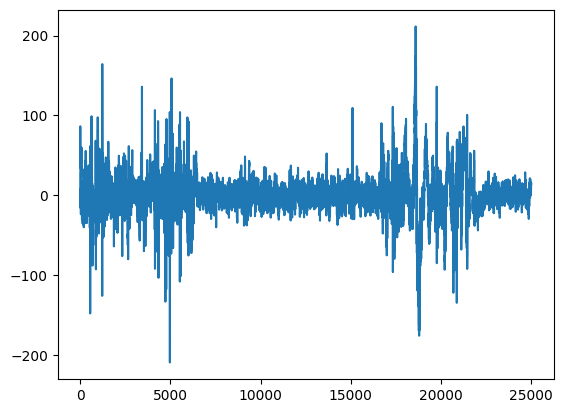

In [171]:
import matplotlib.pyplot as plt
plt.plot(dataset[0][0][0, 0, :])

## Morlet Wave Transformation to get Image

In [172]:
import numpy as np
import pywt
from torchvision.transforms.functional import to_pil_image
from transformers import ViTImageProcessor, ViTModel
import time

In [173]:
wavelet = 'morl'
fs = 250  # Sampling frequency in hz
freq_num = 11  # Number of frequencies 
frequencies = [i for i in range(1, freq_num + 1)]
frequencies_norm = np.array(frequencies) / fs  # normalize
scales = pywt.frequency2scale(wavelet, frequencies_norm)
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')


In [174]:
scales

array([203.125     , 101.5625    ,  67.70833333,  50.78125   ,
        40.625     ,  33.85416667,  29.01785714,  25.390625  ,
        22.56944444,  20.3125    ,  18.46590909])

In [145]:
import time

def tensor2img(tensor):
    start_time = time.time()

    tensor_wt, _ = pywt.cwt(tensor[0, 0, :].cpu().numpy(), scales, wavelet, method='conv')
    print(f"Time for inverse wavelet transform: {time.time() - start_time}")

    start_time = time.time()
    tensor_wt = np.expand_dims(tensor_wt, axis=-1)
    print(f"Time for adding an axis: {time.time() - start_time}")

    start_time = time.time()
    tensor_wt = (((tensor_wt - tensor_wt.min()) / tensor_wt.max()) * 255).astype(np.uint8)
    print(f"Time for standardizing the data: {time.time() - start_time}")

    start_time = time.time()
    tensor_wt = np.repeat(tensor_wt, 3, axis=-1)
    print(f"Time for converting to RGB: {time.time() - start_time}")

    start_time = time.time()
    image = to_pil_image(tensor_wt, mode='RGB')
    print(f"Time for converting to PIL image: {time.time() - start_time}")

    start_time = time.time()
    image =  processor(image, return_tensors='pt')['pixel_values']
    print(f"Time for image processing: {time.time() - start_time}")

    return image

In [176]:
start = time.time()
img = tensor2img(dataset[0][0])
end = time.time()
print((end - start) * 512)

Time for inverse wavelet transform: 0.021997690200805664
Time for adding an axis: 2.8848648071289062e-05
Time for standardizing the data: 0.0005655288696289062
Time for converting to RGB: 0.0014646053314208984
Time for converting to PIL image: 0.0003483295440673828
Time for image processing: 0.012372970581054688
19.3914794921875


## Trying STFT

0.003911733627319336
(224, 225, 1)


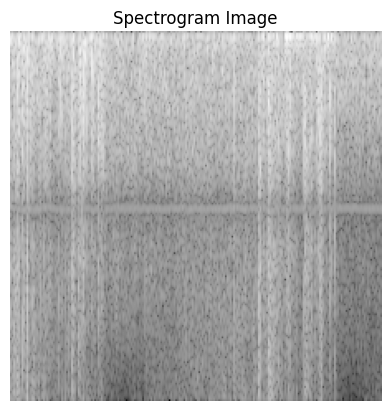

In [208]:
# Load example EEG data
eeg_data = dataset[0][0][0, 0, :]

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# Assuming eeg_data is your 1D EEG signal
fs = 250  # Sampling rate (adjust according to your data)

start = time.time()
_, _, Sxx = spectrogram(eeg_data, fs=fs, nfft=446, nperseg=126)
end = time.time()
print(end - start)

# Normalize the spectrogram for visualization
Sxx_normalized = (10 * np.log10(Sxx) - np.min(10 * np.log10(Sxx))) / (np.max(10 * np.log10(Sxx)) - np.min(10 * np.log10(Sxx)))
Sxx_normalized = np.expand_dims(Sxx_normalized, axis=-1)

print(Sxx_normalized.shape)
# Display the resulting image-like vector
plt.imshow(Sxx_normalized, cmap='gray')
plt.title('Spectrogram Image')
plt.axis('off')  # Turn off axis labels and ticks
plt.show()


In [ ]:
def tensor2img(tensor):
    start_time = time.time()

    _, _, tensor_wt = spectrogram(eeg_data, fs=fs, nfft=446, nperseg=126)    print(f"Time for inverse wavelet transform: {time.time() - start_time}")

    start_time = time.time()
    tensor_wt = np.expand_dims(tensor_wt, axis=-1)
    print(f"Time for adding an axis: {time.time() - start_time}")

    start_time = time.time()
    Sxx_normalized = (10 * np.log10(Sxx) - np.min(10 * np.log10(Sxx))) / (np.max(10 * np.log10(Sxx)) - np.min(10 * np.log10(Sxx)))
    print(f"Time for standardizing the data: {time.time() - start_time}")

    start_time = time.time()
    tensor_wt = np.repeat(tensor_wt, 3, axis=-1)
    print(f"Time for converting to RGB: {time.time() - start_time}")

    start_time = time.time()
    image = to_pil_image(tensor_wt, mode='RGB')
    print(f"Time for converting to PIL image: {time.time() - start_time}")

    start_time = time.time()
    image =  processor(image, return_tensors='pt')['pixel_values']
    print(f"Time for image processing: {time.time() - start_time}")

    return image

In [188]:
Sxx_normalized.shape

(129, 111)

## Getting the embedding of the image using a pretrained ViT

In [118]:
model = ViTModel.from_pretrained('google/vit-base-patch16-224')

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [124]:
pil_image.size

(224, 224)

In [125]:
inputs = processor(pil_image, return_tensors="pt", padding=True)

In [129]:
outputs = model(**inputs)

In [138]:
outputs[0][:, 0, :]

tensor([[ 2.1426e-01,  8.4588e-02,  4.4983e-01, -1.3335e+00, -3.2506e-01,
          7.3643e-01, -1.0452e+00, -3.3053e-02, -1.7167e+00, -2.4341e+00,
          1.5546e-01,  3.5986e-01,  1.9868e-01,  4.6816e-01, -2.3446e-01,
          1.5074e+00, -1.4741e+00, -2.4274e-01, -1.7961e+00,  3.5218e-01,
         -5.2422e-01, -6.7869e-01,  1.7219e-01,  1.3011e+00,  4.9206e-01,
         -1.6554e+00,  9.4720e-01,  2.5655e-01,  1.3905e+00, -7.1469e-01,
         -2.7150e-01,  1.5484e+00, -8.5347e-03, -8.7254e-02,  8.9942e-02,
         -3.4641e-01, -6.5257e-02,  4.6637e-01,  7.7373e-01,  2.5793e-01,
          1.0889e-02,  1.4454e-01, -1.6025e-01, -2.7866e+00,  6.1047e-01,
          1.0521e+00, -1.8162e+00, -4.7628e-01, -1.2387e+00,  7.5015e-01,
          3.4869e-01, -1.9016e-01, -3.4738e-01, -1.3987e-01, -6.4967e-01,
          9.8400e-01,  2.0028e-01, -5.0158e-01,  1.0232e+00, -5.8585e-01,
         -4.5271e-01, -6.9187e-02,  2.0978e-01,  9.5251e-01,  5.3963e-01,
          1.2589e-02, -1.4442e+00,  9.